# Grid Search for Binary Classification - Admissions

In this notebook, we will apply the `GridSearch` algorithm in FairLearn to a binary classification problem, where we also have a binary protected attribute. This algorithm comes from the paper ["A Reductions Approach to Fair Classification" (Agarwal et al. 2018)](https://arxiv.org/abs/1803.02453). The grid search is a simplified version of the full algorithm (appearing in section 3.4), which works best for binary classification and a binary protected attribute.

The specific problem we consider is a biased college admissions problem. We assume that we have a group of males and females (gender will be our protected attribute), with matching standardised test scores and some other irrelevant feature which is correlated with gender. We also have a set of labels denoting whether or not each individual was admitted, and we will make this (generated) historical data biased, by setting a higher threshold for females than males. We will make the standardised test scores independent of gender, so if admissions were unbiased, both genders would be admitted in equal portions.

In [1]:
from fairlearn.reductions import GridSearch
from fairlearn.reductions import DemographicParity

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression

## Generating the Data

We are going to synthesise data for this scenario. We will generate a dataset with two features - "score" and "irrelevant." Both will be follow a normal distribution, but while the "score" feature will be parameterised by a single mean and standard deviation, the "irrelevant" feature will be affected by gender. To create the biased historical labels, we will set different thresholds for each gender (with a small around of normally distributed jitter around each threshold).

The following class implements this:

In [2]:
class DataGenerator:
    def __init__(self):
        # We use label and index 0 for female and 1 for male
        self.number = [400, 900]
        
        self.score_mean = 0.5
        self.score_std_dev = 0.2
        
        self.score_threshold = [0.8, 0.5]
        self.score_threshold_jitter = [0.02, 0.02]
        
        self.irrelevant_mean = [0.4, 0.7]
        self.irrelevant_std_dev = [0.1, 0.1]
        
    def generate(self):
        genders = []
        scores = []
        admissions = []
        irrelevants = []

        for g in range(2):
            s, a, ir = self._generate_single_dataset(self.number[g],
                                                     self.score_threshold[g],
                                                     self.score_threshold_jitter[g],
                                                     self.irrelevant_mean[g],
                                                     self.irrelevant_std_dev[g])
            genders.append(np.full(self.number[g], g))
            scores.append(s)
            admissions.append(a)
            irrelevants.append(ir)
        
        all_scores = np.concatenate( (scores[0], scores[1]), axis=None)
        all_admissions = np.concatenate( (admissions[0], admissions[1]), axis=None)
        all_irrelevants = np.concatenate( (irrelevants[0], irrelevants[1]), axis=None)
        all_genders = np.concatenate( (genders[0], genders[1]), axis=None)
        
        A = pd.Series(data=all_genders, name="Gender")
        X = pd.DataFrame({"score":all_scores,
                          "irrelevant": all_irrelevants})
        Y = pd.Series(data=all_admissions, name="Admitted")
        
        return X, Y, A
        
    def _generate_single_dataset(self,
                                 number_samples,
                                 threshold, threshold_jitter,
                                 irr_mean, irr_std_dev):
        scores = np.random.normal(loc=self.score_mean,
                                  scale=self.score_std_dev,
                                  size=number_samples)
        scores[ scores < 0 ] = 0
        scores[ scores > 1 ] = 1
    
        threshold = np.random.normal(loc=threshold, scale=threshold_jitter, size=number_samples)
        threshold[ threshold < 0 ] = 0
        threshold[ threshold > 1 ] = 1
    
        def admit(s, t): return int(s > t)
    
        vadmit = np.vectorize(admit)
    
        admitted = vadmit(scores, threshold)
    
        irrelevant = np.random.normal(loc=irr_mean, scale=irr_std_dev, size=number_samples)
    
        return scores, admitted, irrelevant
        

We then use this class to generate the data:

In [3]:
dg = DataGenerator()

X, Y, A = dg.generate()

We will use `matplotlib` to examine some of the data. First we examine the distribution of the data in the `X` feature array. As expected, the "score" feature has an identical distribution, but the "irrelevant" feature shows a gender difference

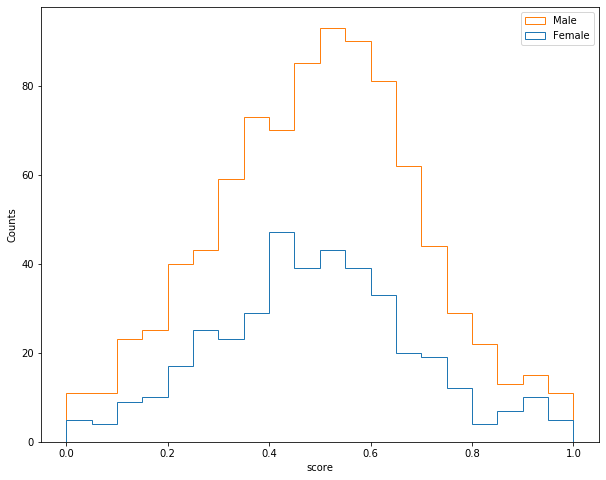

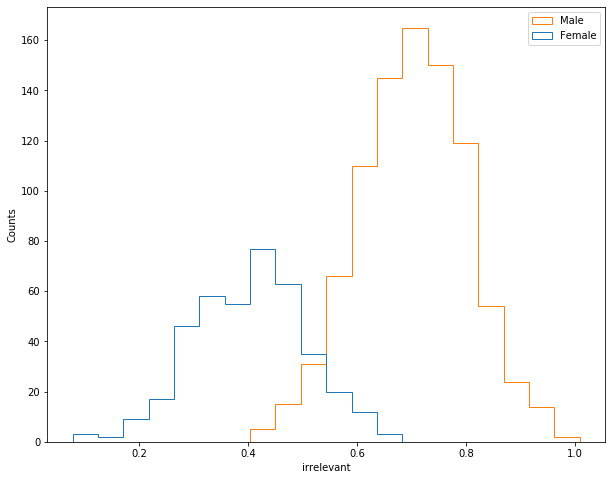

In [6]:
import matplotlib.pyplot as plt
plot_width = 10
plot_height = 8
plt.rcParams["figure.figsize"] = (plot_width, plot_height) # (w, h)

# Nice caption text
gender_labels = ["Female", "Male"]

# Plot two histograms for the given column
def histograms(X_s, A_s, col_name):
    
    sep_data = [X_s[col_name][A_s==0], X_s[col_name][A_s==1]]
    
    plt.hist(sep_data, histtype="step", bins=20, label=gender_labels)
    plt.xlabel(col_name)
    plt.ylabel("Counts")
    plt.legend()
    plt.show()
    
histograms(X, A, "score")
histograms(X, A, "irrelevant")

We can also examine whether each individual was admitted as a function of their test score. This clearly shows the bias against females:

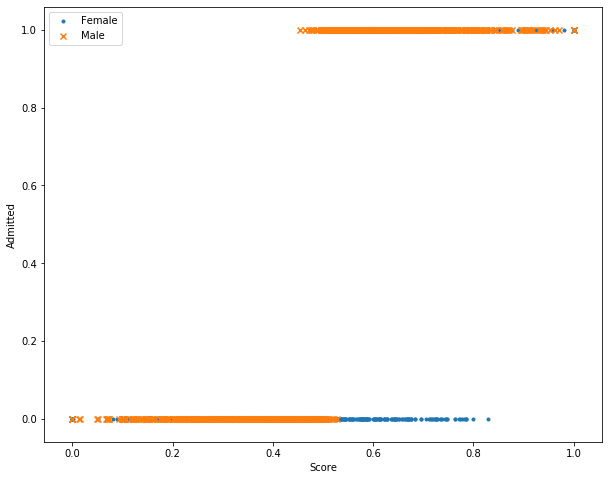

In [7]:
def plot_admissions_vs_scores(X_s, Y_s, A_s):
    markers=[".", "x"]
    for i in range(2):
        mask = A_s == i
        plt.scatter(X_s[mask].score, Y_s[mask], label=gender_labels[i], marker=markers[i])
    plt.xlabel("Score")
    plt.ylabel("Admitted")
    plt.legend()
    plt.show()
    
plot_admissions_vs_scores(X, Y, A)

Finally, we can plot the above data in a slightly different way - as the fraction of each gender admitted:

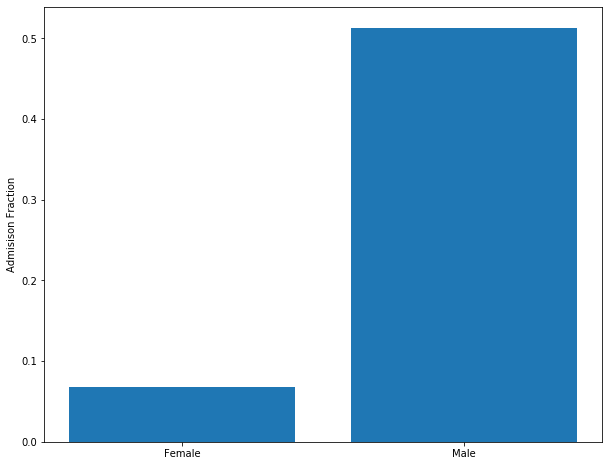

In [8]:
def plot_admission_fractions(Y_s, A_s):
    f_frac = np.mean(Y_s[A_s==0])
    m_frac = np.mean(Y_s[A_s==1])
    
    plt.bar(x=range(2), height=[f_frac, m_frac], tick_label=gender_labels)
    plt.ylabel("Admisison Fraction")
    plt.show()
    
plot_admission_fractions(Y, A)

## Splitting the Data

Before training models, we first perform a standard split of the data into 'train' and 'test' subsets:

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test, A_train, A_test = train_test_split(X, Y, A,
                                                                     test_size = 0.2,
                                                                     random_state=0,
                                                                     stratify=Y)

# Work around indexing bug
X_train = X_train.reset_index(drop=True)
Y_train = Y_train.reset_index(drop=True)
A_train = A_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
Y_test = Y_test.reset_index(drop=True)
A_test = A_test.reset_index(drop=True)

## Training an Unmitigated Model

Before we try mitigating the bias, we can first try training a naive model. For simplicity, we will use the `LogisticRegression` estimator from `sklearn`. Once the model is trained, we can examine the values of the `coef_` array which stores the coefficients of each column from the model - the first corresponds to the "score" feature, while the second corresponds to the "irrelevant" feature. We can see that there is a non-zero weight on the "irrelevant" feature.

In [10]:
unmitigated_model = LogisticRegression(solver='liblinear', fit_intercept=True)
unmitigated_model.fit(X_train, Y_train)

unmitigated_model.coef_

array([[8.45985157, 4.233121  ]])

We can also obtain predictions from this model, and examine them. It's obvious that the bias has been maintained, although it is not quite as dramatic as in the raw data:

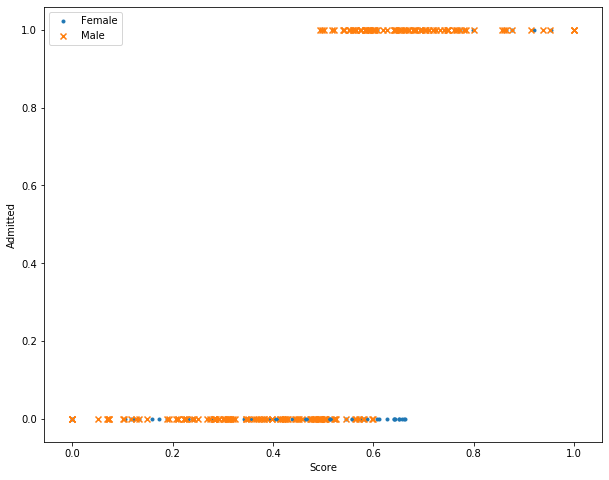

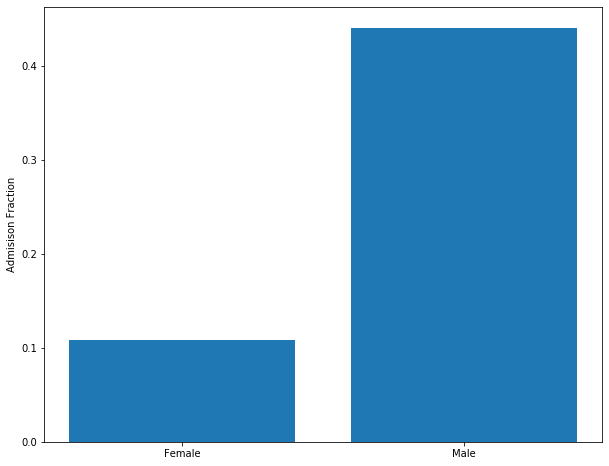

In [11]:
Y_predict_unmitigated = unmitigated_model.predict(X_test)

plot_admissions_vs_scores(X_test, Y_predict_unmitigated, A_test)
plot_admission_fractions(Y_predict_unmitigated, A_test)

Finally, we can examine metrics for this model. `fairlearn` implements group metrics, which apply a given metric function to the entire dataset, and also subgroups within it. First, we can look at the error, as calculated by the `zero_one_loss` function from `sklearn` as wrapped by `fairlearn`:

In [12]:
from fairlearn.metrics import group_zero_one_loss

unmitigated_error = group_zero_one_loss(Y_test, Y_predict_unmitigated, A_test)
print("Overall error     {0:.4f}".format(unmitigated_error.overall))
print("Error for females {0:.4f}".format(unmitigated_error.by_group[0]))
print("Error for males   {0:.4f}".format(unmitigated_error.by_group[1]))

Overall error     0.0962
Error for females 0.0602
Error for males   0.1130


The `group_mean_prediction` metric allows us to see the fraction of each group admitted, as well as the range of admission fractions, which is the disparity in this context. This disparity is what we seek to reduce.

In [13]:
from fairlearn.metrics import group_mean_prediction

unmitigated_mean_prediction = group_mean_prediction(Y_test, Y_predict_unmitigated, A_test)
print("Overall Admission Rate  {0:.4f}".format(unmitigated_mean_prediction.overall))
print("Female Admission Rate   {0:.4f}".format(unmitigated_mean_prediction.by_group[0]))
print("Male Admission Rate     {0:.4f}".format(unmitigated_mean_prediction.by_group[1]))
print("Disparity in Admissions {0:.4f}".format(unmitigated_mean_prediction.range))

Overall Admission Rate  0.3346
Female Admission Rate   0.1084
Male Admission Rate     0.4407
Disparity in Admissions 0.3322


## Reducing Unfairness with Grid Search

Now, we move on to attempting to reduce the unfairness in our model using the grid search. This tries a series of different models, parameterised by a Lagrange multiplier $\lambda_i$. For each value of $\lambda$, the algorithm reweights and relabels the input data, and trains a fresh model ($\lambda=0$ corresponds to the unaltered case).

The grid search acts like a normal `sklearn` estimator, implementing `fit()` and `predict()` methods. The `fit()` method performs the grid search, and the best model found (according to a specified selection rule) is used in `predict()` calls. However, after `fit()` is called, there are two extra properties on the estimator - a `best_result` and a list `all_results`; the `best_result` is used by `predict()` while `all_results` corresponds to the output of the grid search itself. The items in each are dictionaries, each with four entries - `lambda_vec`, `objective`, `gamma` and `predictor`.

We start by telling the algorithm that we want to try 7 different values of $\lambda$ (which are generated for us). We specify demographic parity as our constraint - since the distribution of scores is the same for both genders, we should expect that the admission fraction for each should be the same.

In [14]:
first_sweep=GridSearch(LogisticRegression(solver='liblinear', fit_intercept=True),
                       constraints=DemographicParity(),
                       grid_size=9)

first_sweep.fit(X_train, Y_train, sensitive_features=A_train)

We can examine the values of $\lambda_i$ chosen for us:

In [15]:
lambda_vecs = [x.lambda_vec for x in (first_sweep.all_results)]
lambda_vecs[0]

sign  event  group_id
+     all    0           0.0
             1           0.0
-     all    0           2.0
             1           0.0
Name: 0, dtype: float64

This is rather more than a single value $\lambda$, so what's going on? These results are the outputs of the `Moment` type which drives the reduction approach to removing disparity. There are actually four Lagrange multipliers here, indexed by a tuple (sign, event, group_id). The 'group_id' field corresponds to the labels 0 (for "female") and 1 (for "male", while the 'event' field is the same in all cases (this is because we have specified Demographic Parity as our disparity criterion). Finally the 'sign' comes from the reductions approach specifying separate multipliers for violations of the disparity criterion from above and below. Both of these are constrained to be positive.

So we have four multipliers - $\lambda_{(+,0)}$, $\lambda_{(-,0)}$, $\lambda_{(+,1)}$ and $\lambda_{(-,1)}$. Without losing generality, we can decide to modify one of these, but not the other, and the `DemographicParity` object we passed to the `GridSearch` constructor chose to make $\lambda_{(+,0)}=\lambda_{(-,0)}=0$. Finally, we can combine the 'above' and 'below' multipliers for the other group and obtain $\lambda_i = \lambda_{(+,1)} - \lambda_{(-,1)}$:

In [16]:
actual_multipliers = [x[("+", "all", 1)]-x[("-", "all", 1)] for x in lambda_vecs]
actual_multipliers

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

And we can look at how the weight the models place on the protected attribute (recall that in the fair case, this would be zero) varies with $\lambda_i$

In [ ]:
first_sweep_irrelevant_weights = [
    x.predictor.coef_[0][1] for x in first_sweep.all_results
]

plt.scatter(actual_multipliers, first_sweep_irrelevant_weights)
plt.xlabel("Lagrange Multiplier")
plt.ylabel("Weight on irrelevant feature")
plt.show()

The `GridSearch` object also implements a `predict` method which is routed to the model determined to be the best.

In [ ]:
Y_first_sweep = first_sweep.predict(X_test)

plot_admissions_vs_scores(X_test, Y_first_sweep, A_test)
plot_admission_fractions(Y_first_sweep, A_test)

If we look at the `best_model` on the `GridSearch` object we see that the case where $\lambda=0.5$ was the best in this case.

In [ ]:
lambda_best = first_sweep.best_result.lambda_vec[("+", "all", 1)]-first_sweep.best_result.lambda_vec[("-", "all", 1)]
print("lambda_best = ", lambda_best)

Finally, we can examine the error and disparity for the best model. The error goes up, but that is expected since more females are admitted than were historically. Indeed, we see the disparity in the admission rate has fallen.

In [ ]:
first_sweep_error = group_zero_one_loss(Y_test, Y_first_sweep, A_test)
print("Overall error     {0:.4f}".format(first_sweep_error.overall))
print("Error for females {0:.4f}".format(first_sweep_error.by_group[0]))
print("Error for males   {0:.4f}".format(first_sweep_error.by_group[1]))

first_sweep_mean_prediction = group_mean_prediction(Y_test, Y_first_sweep, A_test)
print("Overall Admission Rate  {0:.4f}".format(first_sweep_mean_prediction.overall))
print("Female Admission Rate   {0:.4f}".format(first_sweep_mean_prediction.by_group[0]))
print("Male Admission Rate     {0:.4f}".format(first_sweep_mean_prediction.by_group[1]))
print("Disparity in Admissions {0:.4f}".format(first_sweep_mean_prediction.range))

### Performing a Second Sweep

We can generate our own set of $\lambda$ values based on the best one before

In [ ]:
n_second_sweep = 51
second_sweep_multipliers = np.linspace(lambda_best-0.5, lambda_best+0.5, n_second_sweep)

iterables = [['+', '-'], ['all'], [0, 1]]
midx = pd.MultiIndex.from_product(iterables, names=['sign', 'event', 'group_id'])

second_sweep_lambdas = []
for l in second_sweep_multipliers:
    nxt = pd.Series(np.zeros(4), index=midx)
    if l < 0:
        nxt[("-", "all", 1)] = abs(l)
    else:
        nxt[("+", "all", 1)] = l
    second_sweep_lambdas.append(nxt)
    
multiplier_df = pd.concat(second_sweep_lambdas,axis=1)

We then use these multipliers in a new `GridSearch`

In [ ]:
second_sweep=GridSearch(LogisticRegression(solver='liblinear', fit_intercept=True),
                        constraints=DemographicParity(),
                        grid=multiplier_df)

second_sweep.fit(X_train, Y_train, sensitive_features=A_train)

We can look at the weight placed on the "irrelevant" feature as a function of $\lambda$:

In [ ]:
second_sweep_irrelevant_weights = [
    x.predictor.coef_[0][1] for x in second_sweep.all_results
]

plt.scatter(second_sweep_multipliers, second_sweep_irrelevant_weights)
plt.xlabel("Lagrange Multiplier")
plt.ylabel("Weight on irrelevant feature")
plt.show()

We can also compare the weight on the irrelevant feature between the best model here and the original unmitigated model:

In [ ]:
print("Weight on irrelevant feature in unmitigated model", unmitigated_model.coef_[0][1])
print("Weight on irrelevant feature in best model", second_sweep.best_result.predictor.coef_[0][1])

Next, we look at the metrics. Rather than just look at the 'best' model, we can look at the error and disparity values across all models. On the resultant Error-Disparity plot, we can see the range of tradeoffs available to us from this set of models. They are forming what is known as a 'Pareto front' - the best possible set of tradeoffs between error and disparity - recall that on this plot the "best" place to be is the origin.

Another important thing to note in this is that the range on the Error axis is much less than the range on the Disparity axis. If we choose, we can pick a model which almost completely elminates disparity for a much smaller increase in error.

In [ ]:
second_sweep_error = np.zeros(n_second_sweep)
second_sweep_disparity = np.zeros(n_second_sweep)

for i in range(n_second_sweep):
    preds = second_sweep.all_results[i].predictor.predict(X_test)
    second_sweep_error[i] = group_zero_one_loss(Y_test, preds, A_test).overall
    second_sweep_disparity[i] = group_mean_prediction(Y_test, preds, A_test).range

plt.scatter(second_sweep_error, second_sweep_disparity)
plt.xlabel("Error")
plt.ylabel("Disparity")
plt.show()